<a href="https://colab.research.google.com/github/gabrielfernandorey/GGGR/blob/main/LSTM/SRT%20v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRT v5 - Ensayo
### LSTM - Nuevo Dataset

In [75]:
import random
import math
import string
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


### Importamos Datos

In [37]:
!wget https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/Regresion%20lineal/serie_acc_SRT.csv

--2023-05-07 14:57:29--  https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/Regresion%20lineal/serie_acc_SRT.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26984867 (26M) [text/plain]
Saving to: ‘serie_acc_SRT.csv.3’

serie_acc_SRT.csv.3 100%[===================>]  25.73M   158MB/s    in 0.2s    

2023-05-07 14:57:29 (158 MB/s) - ‘serie_acc_SRT.csv.3’ saved [26984867/26984867]



In [38]:
df = pd.read_csv('/content/serie_acc_SRT.csv', header=0, sep=';',
                 names=['año','mes','codigo','total_cp'],
                 dtype={'año': str, 'mes': str, 'codigo': str, 'total_cp': str})

In [39]:
column_order = ['codigo', 'año', 'mes', 'total_cp']
new_df = df.reindex(columns=column_order)
df = new_df.copy()

In [40]:
df

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1
...,...,...,...,...
1470273,05582000,2023,5,1
1470274,01754000,2023,5,7
1470275,03503000,2023,5,3
1470276,X5000FJA,2023,5,1


### EDA

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470278 entries, 0 to 1470277
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   codigo    1469958 non-null  object
 1   año       1470278 non-null  object
 2   mes       1470278 non-null  object
 3   total_cp  1470278 non-null  object
dtypes: object(4)
memory usage: 44.9+ MB


#### Ajustamos tipo de datos

In [42]:
df['año'] = pd.to_numeric(df['año'], downcast='integer') #corregimos el formato de la columna 

In [43]:
df['mes'] = pd.to_numeric(df['mes']) #corregimos el formato de la columna 

In [44]:
df['total_cp'] = pd.to_numeric(df['total_cp']) #corregimos el formato de la columna 

In [45]:
df.dtypes

codigo      object
año          int16
mes          int64
total_cp     int64
dtype: object

In [46]:
df.head()

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1


### Eliminamos NaN

In [47]:
df = df.dropna(subset=['codigo'])
df

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1
...,...,...,...,...
1470273,05582000,2023,5,1
1470274,01754000,2023,5,7
1470275,03503000,2023,5,3
1470276,X5000FJA,2023,5,1


In [48]:
df = df.sort_values(['año','mes'], ascending=True)
df

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1
...,...,...,...,...
1470273,05582000,2023,5,1
1470274,01754000,2023,5,7
1470275,03503000,2023,5,3
1470276,X5000FJA,2023,5,1


In [49]:
# Verificar cuantos registros tienen el codpos mayor a 8 caracteres
df_codigo = df.loc[df['codigo'].apply(lambda x: len(str(x)) > 8)]
df_codigo

,codigo,año,mes,total_cp


In [50]:
# Verificar cuantos registros tienen el codpos menor a 4 caracteres
df_codigo = df.loc[df['codigo'].apply(lambda x: len(str(x)) < 4)]
df_codigo

,codigo,año,mes,total_cp


### Convertimos el codigo postal a 4 caracteres

In [51]:
df.codigo = df['codigo'].str.slice(start=1, stop=5)
df

,codigo,año,mes,total_cp
0,1657,1995,1,1
1,8300,1995,7,1
2,1900,1995,9,1
3,1900,1995,11,1
4,1650,1996,3,1
...,...,...,...,...
1470273,5582,2023,5,1
1470274,1754,2023,5,7
1470275,3503,2023,5,3
1470276,5000,2023,5,1


#### Verificamos cantidad de registros por codigo

In [52]:
# codigos unicos
contador = df['codigo'].value_counts()
contador

5000    21916
2000    18100
4000    13459
5500    12482
1425    12020
        ...  
4361        1
6412        1
4677        1
5884        1
3033        1
Name: codigo, Length: 3355, dtype: int64

### Conservamos al menos 12 meses por codigo

In [53]:
mayores_a_12_datos = contador[contador > 12]

In [54]:
len(mayores_a_12_datos)

2610

In [55]:
df = df[df['codigo'].isin(mayores_a_12_datos.index)]

In [56]:
df

,codigo,año,mes,total_cp
0,1657,1995,1,1
1,8300,1995,7,1
2,1900,1995,9,1
3,1900,1995,11,1
4,1650,1996,3,1
...,...,...,...,...
1470273,5582,2023,5,1
1470274,1754,2023,5,7
1470275,3503,2023,5,3
1470276,5000,2023,5,1


### Eliminamos códigos no válidos

In [57]:
df = df.loc[df.codigo != "    "]

In [58]:
df = df.loc[df.codigo != "   0"]

In [59]:
df = df.loc[df.codigo != "0000"]

In [60]:
df = df.loc[df.codigo != "0001"]

In [61]:
df = df.loc[df.codigo != "0005"]

### Transformacion

In [62]:
# Utilizamos la fecha como indice 
df['fecha'] = pd.to_datetime({'year': df['año'],
                               'month': df['mes'],
                               'day': '01'})
df

,codigo,año,mes,total_cp,fecha
0,1657,1995,1,1,1995-01-01
1,8300,1995,7,1,1995-07-01
2,1900,1995,9,1,1995-09-01
3,1900,1995,11,1,1995-11-01
4,1650,1996,3,1,1996-03-01
...,...,...,...,...,...
1470273,5582,2023,5,1,2023-05-01
1470274,1754,2023,5,7,2023-05-01
1470275,3503,2023,5,3,2023-05-01
1470276,5000,2023,5,1,2023-05-01


In [63]:
df = df.set_index('fecha')
df

,codigo,año,mes,total_cp
fecha,,,,
1995-01-01,1657,1995,1,1
1995-07-01,8300,1995,7,1
1995-09-01,1900,1995,9,1
1995-11-01,1900,1995,11,1
1996-03-01,1650,1996,3,1
...,...,...,...,...
2023-05-01,5582,2023,5,1
2023-05-01,1754,2023,5,7
2023-05-01,3503,2023,5,3


### Visualizacion

In [136]:
unicos = pd.unique(df.codigo)
unicos

array(['1657', '8300', '1900', ..., '5224', '7625', '7110'], dtype=object)

In [137]:
codigo_in = random.choice(unicos) 
filtro = df[df.codigo == codigo_in]
filtro

,codigo,año,mes,total_cp
fecha,,,,
2009-06-01,7613,2009,6,1
2009-09-01,7613,2009,9,1
2010-01-01,7613,2010,1,1
2010-01-01,7613,2010,1,1
2010-02-01,7613,2010,2,1
...,...,...,...,...
2023-01-01,7613,2023,1,1
2023-01-01,7613,2023,1,2
2023-01-01,7613,2023,1,1


In [145]:
filtro.tail(1).index[0]

Timestamp('2023-04-01 00:00:00')

Text(0, 0.5, 'Accidentes')

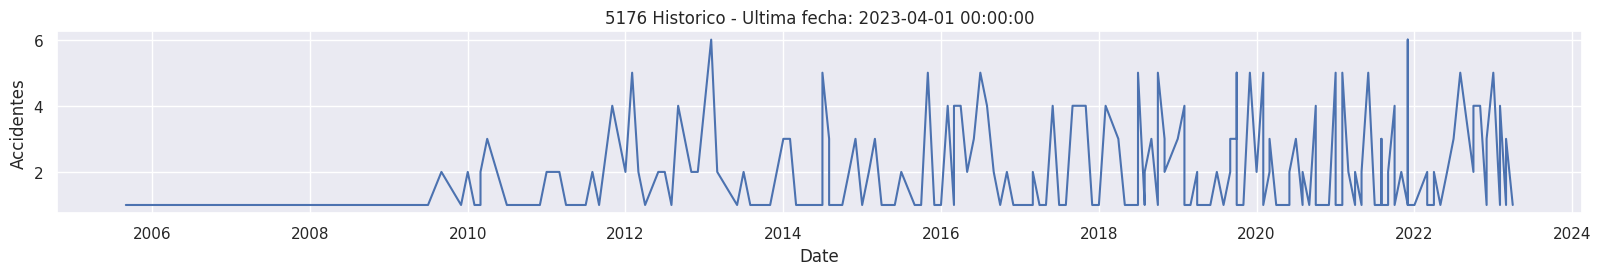

In [147]:
codigo_in = random.choice(unicos) 
filtro = df[df.codigo == codigo_in]
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico'+' - Ultima fecha: '+ str(filtro.tail(1).index[0]))
plt.plot(filtro['total_cp'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12)

### Preparamos datos

In [148]:
data = filtro.filter(['total_cp'])

In [172]:
# Convertimos a numpy array
dataset = data.values
len(dataset)

202

### Transformar la variable de salida

In [150]:
mmscaler = MinMaxScaler()

In [151]:
data_scaled = mmscaler.fit_transform(dataset)

### Pre-entrenamiento

In [152]:
# Calculamos cantidad de datos para training y para test
training_data_len = math.ceil(len(dataset) * .8)
training_data_len 

162

In [173]:
# Prepara datos de entrenamiento
train_data = data_scaled[0:training_data_len, : ]
len(train_data)

162

In [174]:
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [178]:
#Convertir a numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [179]:
X_train.shape

(102, 60)

In [180]:
#Reshape 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(102, 60, 1)

### Modelo

In [182]:
dim_entrada = (X_train.shape[1], 1)  # dimension 60
dim_salida = 1

modelo = Sequential()
modelo.add(LSTM(units=50, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))

In [183]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [184]:
modelo.compile(optimizer='rmsprop', loss='mse')

In [185]:
modelo.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
4/4 [==============================] - 2s 28ms/step - loss: 0.1073
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 0.0771
Epoch 3/20
4/4 [==============================] - 0s 32ms/step - loss: 0.0765
Epoch 4/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0754
Epoch 5/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0764
Epoch 6/20
4/4 [==============================] - 0s 43ms/step - loss: 0.0772
Epoch 7/20
4/4 [==============================] - 0s 41ms/step - loss: 0.0760
Epoch 8/20
4/4 [==============================] - 0s 42ms/step - loss: 0.0756
Epoch 9/20
4/4 [==============================] - 0s 42ms/step - loss: 0.0746
Epoch 10/20
4/4 [==============================] - 0s 44ms/step - loss: 0.0764
Epoch 11/20
4/4 [==============================] - 0s 55ms/step - loss: 0.0751
Epoch 12/20
4/4 [==============================] - 0s 51ms/step - loss: 0.0752
Epoch 13/20
4/4 [==============================] - 0s 44ms/st

### Prediccion

In [161]:
# Ultimos 60 valores del dataframe a array
last_60_days_scaled = data_scaled[-60:, : ]

In [187]:
len(data_scaled), len(last_60_days_scaled)

(202, 60)

In [188]:
X_test_new = []
X_test_new.append(last_60_days_scaled)
X_test_new = np.array(X_test_new)
X_test_new = np.reshape(X_test_new, (1, 60, 1))  # Entramos con un 1 vector de dimension 60

In [189]:
pred = modelo.predict(X_test_new)
pred = mmscaler.inverse_transform(pred)

1/1 [==============================] - 0s 460ms/step


In [191]:
print(f"Prediccion para el código {codigo_in} para la fecha {filtro.tail(1).index[0]}: {round(pred[0][0])} incidentes")  

Prediccion para el código 5176 para la fecha 2023-04-01 00:00:00: 2 incidentes


### Visualizar

In [192]:
X_test_new = np.reshape(X_test_new, (1, 60))

In [193]:
last_60 = mmscaler.inverse_transform(X_test_new)

In [167]:
df_incidentes = pd.DataFrame(last_60)

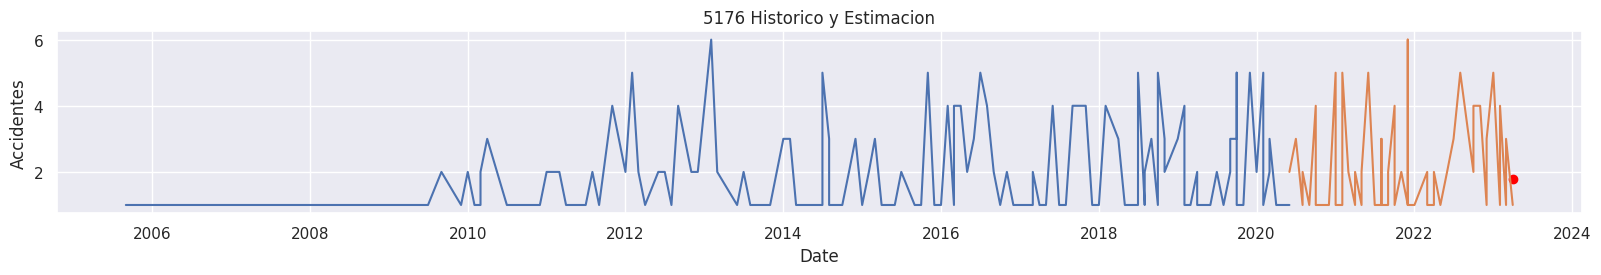

In [194]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico y Estimacion')
plt.plot(data[:-60])
plt.plot(data[-60:])
plt.scatter([filtro.tail(1).index[0]], pred, color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Evaluacion para los proximos 6 meses

In [234]:
X_test_new.shape

(1, 60)

In [235]:
# Elimino el primer elemento
X_test_proximo = np.delete(X_test_new, 0, axis=1) 

In [236]:
X_test_proximo = np.append(X_test_proximo, round(pred[0][0]))

In [239]:
X_test_proximo = mmscaler.transform(X_test_proximo.reshape(-1, 1))

In [241]:
X_test_proximo.shape

(60, 1)

In [238]:

pred = modelo.predict(X_test_proximo)
pred = mmscaler.inverse_transform(pred)

TypeError: ignored

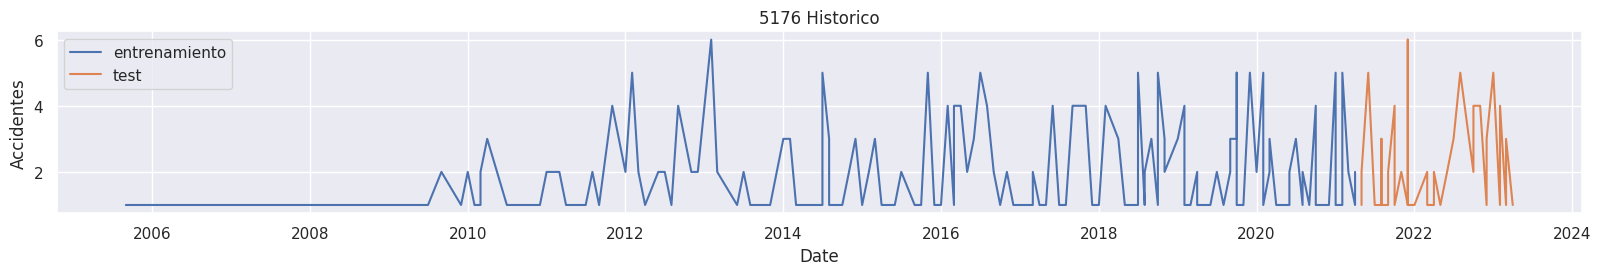

In [206]:
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico')
plt.plot(filtro['total_cp'][:162], label='entrenamiento')
plt.plot(filtro['total_cp'][162:], label='test')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12)
plt.legend();